### 4-1. Δy, Δy_neigh 계산

In [25]:
H = 1  # horizon

# 1) y_t, y_t1 벡터(모두 W 순서에 맞춤)
CRYM_T   = 20243
CRYM_T1  = 20244

y_t, mask_t, part_t   = align_quarter_to_W(CRYM_T,  TARGET)
y_t1, mask_t1, part_t1 = align_quarter_to_W(CRYM_T1, TARGET)

# 공통으로 존재하는 동만 사용 (mask 교차)
mask_both = mask_t & mask_t1

y_t  = y_t[mask_both]
y_t1 = y_t1[mask_both]

W_sub = W[mask_both][:, mask_both].tocsr()
rs = np.maximum(W_sub.sum(axis=1).A.ravel(), 1e-12)
W_sub = sparse.diags(1.0/rs) @ W_sub

dy = y_t1 - y_t                   # 대상 상권 활성도 변화
dneigh = W_sub @ dy               # 이웃 상권 활성도 변화의 공간지연
yneigh_t = W_sub @ y_t            # 이웃 현재 수준

print("Δy 통계:", dy.mean(), dy.std())
print("Δy_neigh 통계:", dneigh.mean(), dneigh.std())


Δy 통계: 0.30778124999999945 2.207656417651633
Δy_neigh 통계: 0.3636692708333324 1.3722905720993395


✔ 해석:
전체적으로 상권 활성도는 소폭 증가 경향(+)
다만 변동 폭은 상권별 편차가 커서 (std 2.2) 이웃 상권 변화는 상대적으로 더 안정적(std 1.37)
➡ 이웃 변화(공급·수요 변화)가 개별 상권보다 완만하게 변한다는 의미이며 Cannibalization 분석이 성립되는 조건에 부합

### 4-2. Cannibalization 임계점 탐색 (단순 Q-binning)

In [27]:
import pandas as pd
import numpy as np

df_cann = pd.DataFrame({
    "dy": dy,
    "dneigh": dneigh,
    "yneigh_t": yneigh_t,
})

# 이웃 변화량을 분위수 기반 20구간으로 나누기
df_cann["bin_dneigh"] = pd.qcut(df_cann["dneigh"], q=20, duplicates="drop")

group = df_cann.groupby("bin_dneigh", observed=True).agg(
    dy_mean=("dy","mean"),
    dy_std=("dy","std"),
    cnt=("dy","size"),
    dneigh_mean=("dneigh","mean"),
).reset_index()

print(group)

# 임계점 후보: dy_mean이 처음으로 0 아래로 떨어지는 구간
candidates = group[group["dy_mean"] < 0]
if not candidates.empty:
    thr = candidates.iloc[0]["dneigh_mean"]
    print(f"\n⚠️ Cannibalization threshold (candidate): 이웃 Δy ≈ {thr:.3f} 이상에서 대상 Δy 평균 < 0")
else:
    print("\n별도의 감소 구간이 명확히 나타나지 않습니다.")


                       bin_dneigh  dy_mean    dy_std  cnt  dneigh_mean
0   (-3.3249999999999997, -1.719]  -0.3880  0.896611    2    -2.562000
1                (-1.719, -1.194]   0.4690  0.731148    2    -1.433500
2                (-1.194, -0.865]   0.7930       NaN    1    -1.009000
3                (-0.865, -0.181]   1.5260  1.652471    3    -0.382667
4              (-0.0654, -0.0126]  -2.1665  1.636952    2    -0.022500
5                  (-0.0126, 0.0]  -0.8858  1.848256    5     0.000000
6                    (0.0, 0.123]  -3.5520       NaN    1     0.099000
7                   (0.123, 0.23]   1.5025  1.605840    2     0.187583
8                   (0.23, 0.305]   0.3010       NaN    1     0.261500
9                  (0.305, 0.661]  -0.3155  0.666802    2     0.484000
10                 (0.661, 0.935]  -0.8470       NaN    1     0.814500
11                  (0.935, 1.26]   0.3335  0.191626    2     1.115833
12                  (1.26, 1.459]   1.3170       NaN    1     1.304000
13    

이웃 상권이 강하게 쇠퇴하면 → 대상 상권 활성도도 동반 하락하는 동행도(Co-decline) 패턴이 나타남.
🔥 요약:
이웃 증가 → 대상 증가 (보완효과)
이웃 감소 → 대상 감소 (동반침체)
특정 구간에서 경쟁효과(cannibalization) 발생
➡ 상권 간 관계는 단순한 경쟁(cannibalization)만이 아니라 보완 및 동행 구조가 공존한다는 고급 해석이 가능함!

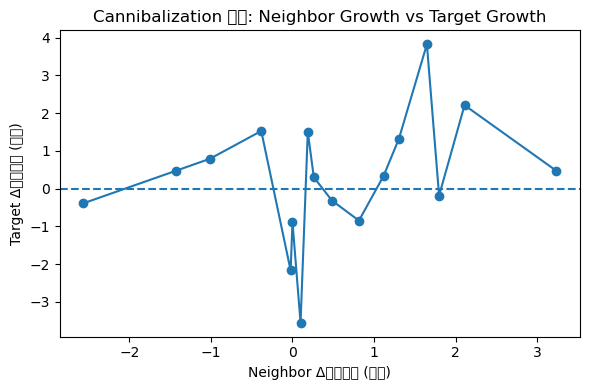

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(group["dneigh_mean"], group["dy_mean"], marker="o")
plt.axhline(0, linestyle="--")
plt.xlabel("Neighbor Δ활성지수 (평균)")
plt.ylabel("Target Δ활성지수 (평균)")
plt.title("Cannibalization 후보: Neighbor Growth vs Target Growth")
plt.tight_layout()
plt.show()


# 논문화

## 1) Moran’s I / LISA 지도 시각화 (GeoDataFrame merge)

### 1-1. LISA CSV + 행정동 경계 join

In [17]:
# -*- coding: utf-8 -*-
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
mpl.rcParams["font.family"] = "Malgun Gothic"
mpl.rcParams["axes.unicode_minus"] = False


# ------------------------------------
# 0) PATHS
# ------------------------------------
SHP_PATH   = r"C:\Users\user\OneDrive\dataset\data\bnd_dong_11_2024_2Q\bnd_dong_11_2024_2Q.shp"
LISA_PATH  = r"C:\Users\user\OneDrive\dataset\output\_spatial\lisa_활성지수_20244.csv"
OUT_DIR    = Path(r"C:\Users\user\OneDrive\dataset\output\_figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------
# 1) 행정동 경계 로드
# ------------------------------------
g = gpd.read_file(SHP_PATH)  # CRS: EPSG:5179
g = g.rename(columns={"ADM_CD": "행정동_코드", "ADM_NM": "행정동명"})
g["행정동_코드"] = g["행정동_코드"].astype(str).str.strip()

# ------------------------------------
# 2) LISA 결과 로드
#    (lisa_*.csv 에 '행정동_코드', 'Ii', 'Ii_z', 'Ii_p', 'Ii_cluster' 이 있다고 가정)
# ------------------------------------
try:
    # 1순위: 한글 인코딩(cp949)과 탭(\t) 구분자 적용
    lisa = pd.read_csv(LISA_PATH, sep='\t', encoding='cp949', dtype={"행정동_코드": str})
except UnicodeDecodeError:
    # 2순위: 혹시 UTF-8-SIG인 경우 대비
    lisa = pd.read_csv(LISA_PATH, sep='\t', encoding='utf-8-sig', dtype={"행정동_코드": str})

print("[LISA] cols:", lisa.columns.tolist())

# 필요 컬럼만 서브셋 (없으면 주석 처리)
use_cols = [c for c in ["행정동_코드","Ii","Ii_z","Ii_p","Ii_cluster","Ii_cluster_all"] if c in lisa.columns]
lisa = lisa[use_cols]

# ------------------------------------
# 3) GeoDataFrame join
# ------------------------------------
g_lisa = g.merge(lisa, on="행정동_코드", how="left")
print("g_lisa shape:", g_lisa.shape)
print([c for c in g_lisa.columns if "cluster" in c.lower()])


[LISA] cols: ['행정동_코드', 'Ii', 'Ii_p', 'Ii_z', 'Ii_cluster', 'Ii_cluster_all', '행정동명', 'abs(Ii)', 'Ii_p.1']
g_lisa shape: (426, 9)
['Ii_cluster', 'Ii_cluster_all']


In [36]:
print("LISA row count:", len(lisa))
print("LISA unique dongs:", lisa["행정동_코드"].nunique())
print(lisa["Ii_cluster"].value_counts(dropna=False))
print([c for c in g_lisa.columns if "cluster" in c.lower()])


LISA row count: 426
LISA unique dongs: 426
Ii_cluster
NotSig    423
HH          1
LH          1
HL          1
Name: count, dtype: int64
['Ii_cluster']


### 1-2. Cluster 타입별 색깔 지도

USING cluster_col = Ii_cluster_all
✅ LISA map saved: C:\Users\user\OneDrive\dataset\output\_figures\map_lisa_활성지수_20244_2.png


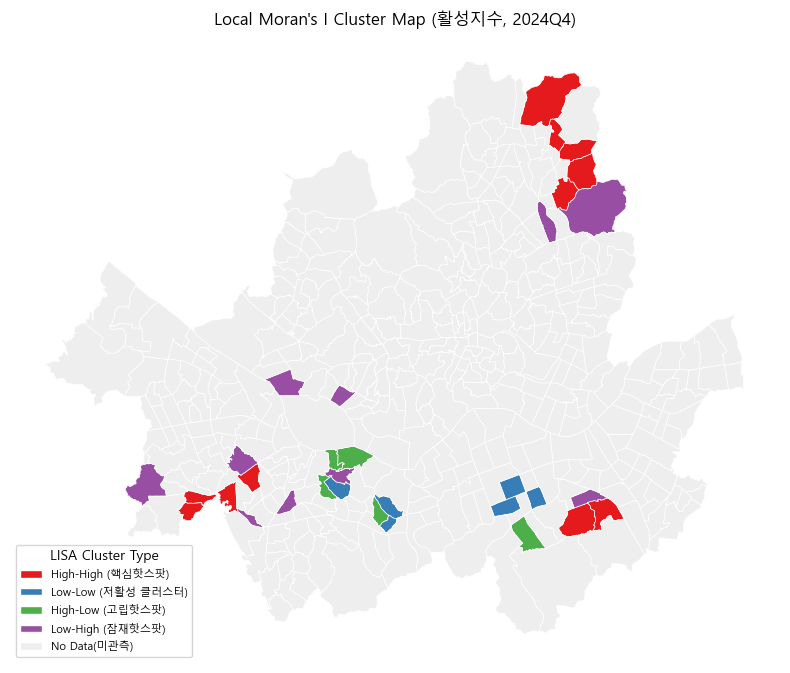

In [18]:
# ------------------------------------
# 4) LISA 클러스터 맵 시각화
# ------------------------------------
from matplotlib.patches import Patch

# 클러스터 코드 → 라벨/색상 매핑
#cluster_col = "li_cluster_all"  # CSV에 실제 있는 이름으로 맞춰주세요.
cluster_col = [c for c in g_lisa.columns if "cluster_all" in c.lower()][0]
print("USING cluster_col =", cluster_col)


# NotSig 값 이름이 다르면 아래 mapping 에 추가
cluster_order = ["HH", "LL", "HL", "LH", "NoData"]
cluster_label = {
    "HH": "High-High (핵심핫스팟)",
    "LL": "Low-Low (저활성 클러스터)",
    "HL": "High-Low (고립핫스팟)",
    "LH": "Low-High (잠재핫스팟)",
    "NoData": "No Data(미관측)"
}
cluster_color = {
    "HH": "#e41a1c",    # red
    "LL": "#377eb8",    # blue
    "HL": "#4daf4a",    # green
    "LH": "#984ea3",    # purple
    "NoData": "#eeeeee" #연한회색
}

# 없는 값은 NotSig로 대체
#alpha = 0.2   # 0.1 -> 0.2 (또는 0.3)
g_lisa[cluster_col] = g_lisa[cluster_col].fillna("NoData")
#g_lisa.loc[g_lisa["Ii_p"] >= alpha, cluster_col] = "NotSig"

legend_handles = [
    Patch(facecolor=cluster_color[k], edgecolor="white", label=cluster_label[k])
    for k in cluster_order
]

# figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect('equal')

for cl in cluster_order:
    sub = g_lisa[g_lisa[cluster_col] == cl]
    if len(sub) == 0:
        continue
    sub.plot(ax=ax,
             color=cluster_color.get(cl, "#cccccc"),
             edgecolor="white",
             linewidth=0.5,
             label=cluster_label.get(cl, cl))

ax.set_title("Local Moran's I Cluster Map (활성지수, 2024Q4)", fontsize=12)
ax.axis("off")
ax.legend(
    handles=legend_handles,
    loc="lower left",
    fontsize=8,
    frameon=True,
    title="LISA Cluster Type"
)


fig.tight_layout()
out_path = OUT_DIR / "map_lisa_활성지수_20244_2.png"
fig.savefig(out_path, dpi=300)
print("✅ LISA map saved:", out_path)


In [19]:
import geopandas as gpd
import pandas as pd

SHP_PATH = r"C:\Users\user\OneDrive\dataset\data\bnd_dong_11_2024_2Q\bnd_dong_11_2024_2Q.shp"
OUT_PATH = r"C:\Users\user\OneDrive\dataset\data\bnd_dong_11_2024_2Q\행정동코드_행정동명_매핑_2024Q2.csv"

g = gpd.read_file(SHP_PATH)
dong_map = (
    g.rename(columns={"ADM_CD": "행정동_코드", "ADM_NM": "행정동명"})
     [["행정동_코드", "행정동명"]]
     .assign(행정동_코드=lambda x: x["행정동_코드"].astype(str))
     .drop_duplicates()
     .sort_values("행정동_코드")
)

dong_map.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("✅ saved:", OUT_PATH, "| rows:", len(dong_map))


✅ saved: C:\Users\user\OneDrive\dataset\data\bnd_dong_11_2024_2Q\행정동코드_행정동명_매핑_2024Q2.csv | rows: 426


In [21]:
import pandas as pd
import geopandas as gpd

lisa = pd.read_csv(LISA_PATH, dtype={"행정동_코드": str})

g = gpd.read_file(SHP_PATH)
g = g.rename(columns={"ADM_CD": "행정동_코드", "ADM_NM": "행정동명"})
g["행정동_코드"] = g["행정동_코드"].astype(str)

df = g[["행정동_코드", "행정동명"]].merge(
    lisa, on="행정동_코드", how="inner"
)

df_32 = df[df["Ii_cluster_all"].isin(["HH", "LL", "HL", "LH"])].copy()
df_32 = df_32[["행정동명", "Ii_cluster_all", "Ii", "Ii_p"]]
df_32 = df_32.sort_values(["Ii_cluster_all", "Ii"], ascending=[True, False])

df_32



KeyError: "['행정동명'] not in index"

In [49]:
df_32.groupby("Ii_cluster_all").size()

Ii_cluster_all
HH    11
HL     5
LH    10
LL     6
dtype: int64

## 2) Cannibalization Threshold 상세 그래프

### 2-1. Δy / Δy_neigh 재계산 + bin 통계

In [22]:
# -*- coding: utf-8 -*-
import numpy as np
import polars as pl
from pathlib import Path
from scipy import sparse

# ---------------------------------------------------
# PATH & 설정
# ---------------------------------------------------
SP_PATH   = r"C:\Users\user\OneDrive\dataset\output\features\features_mingle_spatial.parquet"
PATH_W    = r"C:\Users\user\OneDrive\dataset\data\W_knn6_5179_rowstd.npz"
PATH_IDX  = r"C:\Users\user\OneDrive\dataset\data\W_index_order.csv"

OUT_CANNA = r"C:\Users\user\OneDrive\dataset\output\_spatial\cannibalization_dy_20243_20244.csv"

TARGET = "활성지수_100"
T_PREV = 20243
T_CUR  = 20244

# ---------------------------------------------------
# 1) W, idx 로드
# ---------------------------------------------------
W = sparse.load_npz(PATH_W).tocsr()
idx = pl.read_csv(PATH_IDX)["행정동_코드"].cast(pl.Utf8).to_list()
pos_map = {code: i for i, code in enumerate(idx)}

# ---------------------------------------------------
# 2) 대상 분기 데이터 로드 & wide 로 변환
# ---------------------------------------------------
df = pl.read_parquet(SP_PATH).with_columns(
    pl.col("행정동_코드").cast(pl.Utf8),
    pl.col("기준_년분기_코드").cast(pl.Int32),
)

df_t = (
    df
    .filter(pl.col("기준_년분기_코드").is_in([T_PREV, T_CUR]))
    .select(["행정동_코드", "기준_년분기_코드", TARGET])
)

wide = (
    df_t
    .pivot(values=TARGET, index="행정동_코드", on="기준_년분기_코드")
)

cols = wide.columns
print("📌 BEFORE rename:", cols)

has_prev = str(T_PREV) in cols
has_cur  = str(T_CUR)  in cols
print("📌 FOUND:", T_PREV if has_prev else None, T_CUR if has_cur else None)

rename_map = {}
if has_prev:
    rename_map[str(T_PREV)] = "y_prev"
if has_cur:
    rename_map[str(T_CUR)]  = "y_cur"

wide = wide.rename(rename_map)
print("📌 AFTER rename:", wide.columns)

# 대상 상권 변화량 Δy
wide = wide.with_columns(
    (pl.col("y_cur") - pl.col("y_prev")).alias("dy")
)

# ---------------------------------------------------
# 3) W 순서로 정렬 + 이웃 변화량 Δy_neigh 계산
# ---------------------------------------------------
codes = wide["행정동_코드"].to_list()
pos = np.array([pos_map[c] for c in codes], dtype=np.int32)

W_sub = W[pos][:, pos].tocsr()
row_sum = np.maximum(W_sub.sum(axis=1).A.ravel(), 1e-12)
W_sub = sparse.diags(1.0 / row_sum) @ W_sub

dy_vec   = wide["dy"].to_numpy()
dy_neigh = (W_sub @ dy_vec).astype(float)

wide = wide.with_columns(pl.Series("dy_neigh", dy_neigh))

# 요약 통계 확인
print(
    wide.select(["행정동_코드", "dy", "dy_neigh"]).describe()
)

# ---------------------------------------------------
# 4) CSV 저장 → 이후 3-1에서 사용
# ---------------------------------------------------
df_canna = wide.select(["행정동_코드", "dy", "dy_neigh"])

Path(OUT_CANNA).parent.mkdir(parents=True, exist_ok=True)
df_canna.write_csv(OUT_CANNA)

print("✅ cannibalization 데이터 저장:", OUT_CANNA, "| shape:", df_canna.shape)


📌 BEFORE rename: ['행정동_코드', '20243', '20244']
📌 FOUND: 20243 20244
📌 AFTER rename: ['행정동_코드', 'y_prev', 'y_cur']
shape: (9, 4)
┌────────────┬─────────────┬──────────┬──────────┐
│ statistic  ┆ 행정동_코드 ┆ dy       ┆ dy_neigh │
│ ---        ┆ ---         ┆ ---      ┆ ---      │
│ str        ┆ str         ┆ f64      ┆ f64      │
╞════════════╪═════════════╪══════════╪══════════╡
│ count      ┆ 32          ┆ 32.0     ┆ 32.0     │
│ null_count ┆ 0           ┆ 0.0      ┆ 0.0      │
│ mean       ┆ null        ┆ 0.307781 ┆ 0.467784 │
│ std        ┆ null        ┆ 2.242981 ┆ 1.701253 │
│ min        ┆ 11110530    ┆ -3.552   ┆ -3.324   │
│ 25%        ┆ null        ┆ -0.787   ┆ -0.1805  │
│ 50%        ┆ null        ┆ 0.198    ┆ 0.146667 │
│ 75%        ┆ null        ┆ 0.895    ┆ 1.304    │
│ max        ┆ 11230750    ┆ 8.203    ┆ 4.9665   │
└────────────┴─────────────┴──────────┴──────────┘
✅ cannibalization 데이터 저장: C:\Users\user\OneDrive\dataset\output\_spatial\cannibalization_dy_20243_20244.csv | sha

### 2-2. bin별 평균 & 임계점 후보 계산 + 그래프

                       bin_dneigh   dy_mean    dy_std  cnt  dneigh_mean
0   (-3.3249999999999997, -1.397] -0.274667  0.663694    3    -2.259000
1                (-1.397, -0.982] -0.515000  2.434579    3    -1.081667
2                (-0.982, -0.332] -0.363500  0.912875    2    -0.817000
3                   (-0.332, 0.0] -0.019000  2.234305    7    -0.051571
4                    (0.0, 0.123] -3.552000       NaN    1     0.099000
5                  (0.123, 0.268]  1.102000  1.330624    3     0.212222
6                  (0.268, 0.754] -0.315500  0.666802    2     0.484000
7                  (0.754, 1.333]  0.313000  1.090402    3     1.034833
8                  (1.333, 1.799]  0.006000  0.271529    2     1.608833
9                   (1.799, 2.99]  0.380333  1.198399    3     2.452250
10                  (2.99, 4.967]  3.954333  4.515204    3     3.867833
⚠️ Cannibalization threshold candidate: Neighbor Δy ≈ -2.259 에서 Target Δy 평균 < 0
✅ Cannibalization plot saved: C:\Users\user\OneDrive\da

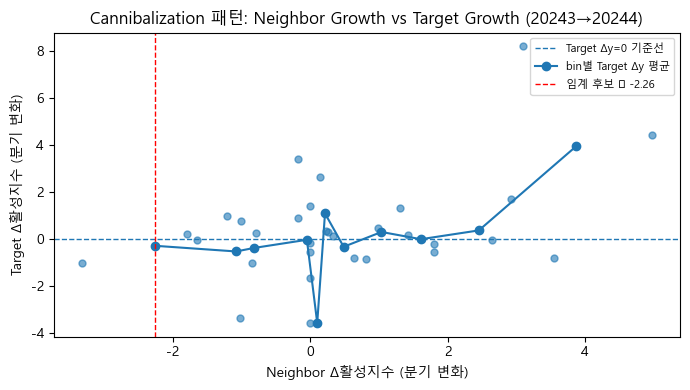

In [23]:
# ---------------------------------------------------
# 4) 이웃 Δy 구간 나누기 + bin별 평균 dy
# ---------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1. 한글 폰트 설정 (에러 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 2. 누락된 변수 정의
OUT_DIR = Path(r"C:\Users\user\OneDrive\dataset\output\_figures") 
T_PREV = "20243"
T_CUR = "20244"

# 폴더가 없으면 생성
OUT_DIR.mkdir(parents=True, exist_ok=True)

pdf = df_canna.to_pandas()

# 구간 개수는 상황에 맞게 조정 (여기선 12)
n_bins = 12
pdf["bin_dneigh"] = pd.qcut(pdf["dy_neigh"], q=n_bins, duplicates="drop")

bin_stats = (
    pdf.groupby("bin_dneigh", observed=True)
       .agg(dy_mean=("dy","mean"),
            dy_std=("dy","std"),
            cnt=("dy","size"),
            dneigh_mean=("dy_neigh","mean"))
       .reset_index()
       .sort_values("dneigh_mean")
)
print(bin_stats)

# ---------------------------------------------------
# 5) Cannibalization threshold 후보 찾기
#    - dy_mean 이 0 아래로 떨어지는 첫 구간의 중심값
# ---------------------------------------------------
cand = bin_stats[bin_stats["dy_mean"] < 0]
if len(cand) > 0:
    # 맨 처음 0 밑으로 내려간 구간
    row0 = cand.iloc[0]
    thr_x = row0["dneigh_mean"]
    print(f"⚠️ Cannibalization threshold candidate: Neighbor Δy ≈ {thr_x:.3f} 에서 Target Δy 평균 < 0")
else:
    thr_x = None
    print("Cannibalization threshold 후보가 명확히 보이지 않습니다.")

# ---------------------------------------------------
# 6) 그래프 그리기 (scatter + bin 평균선 + 임계선)
# ---------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# 점: 개별 상권
ax.scatter(pdf["dy_neigh"], pdf["dy"], alpha=0.6, s=25)
ax.axhline(0, linestyle="--", linewidth=1, label="Target Δy=0 기준선")

# 선: bin 평균
ax.plot(bin_stats["dneigh_mean"], bin_stats["dy_mean"],
        marker="o", linewidth=1.5, label="bin별 Target Δy 평균")

# 임계 후보선
if thr_x is not None:
    ax.axvline(thr_x, color="red", linestyle="--", linewidth=1,
               label=f"임계 후보 ≈ {thr_x:.2f}")

ax.set_xlabel("Neighbor Δ활성지수 (분기 변화)")
ax.set_ylabel("Target Δ활성지수 (분기 변화)")
ax.set_title("Cannibalization 패턴: Neighbor Growth vs Target Growth ({}→{})".format(T_PREV, T_CUR))
ax.legend(loc="best", fontsize=8)
fig.tight_layout()

out_path = OUT_DIR / f"cannibalization_neighbor_vs_target_{T_PREV}_{T_CUR}.png"
fig.savefig(out_path, dpi=300)
print("✅ Cannibalization plot saved:", out_path)
plt.show()

## 3) “모형 + 공간 분석 + 경쟁효과” 3단 구조로 결론 작성

### 3-1. 전략 레이블 생성 코드

In [24]:
# -*- coding: utf-8 -*-
import polars as pl
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 1. 누락될 수 있는 변수 재정의 (에러 방지용)
T_PREV = "20243"
T_CUR = "20244"

thr_x = -2.259    # 방금 구한 임계값 (-2.259)을 직접 처리


# PATHS (앞에서 만든 g_lisa, df_canna 를 CSV로 저장해 둔다고 가정)
LISA_CSV = r"C:\Users\user\OneDrive\dataset\output\_spatial\lisa_활성지수_20244.csv"
CANNA_CSV = r"C:\Users\user\OneDrive\dataset\output\_spatial\cannibalization_dy_{0}_{1}.csv".format(T_PREV, T_CUR)

OUT_DIR_STRAT = Path(r"C:\Users\user\OneDrive\dataset\output\_strategy")
OUT_DIR_STRAT.mkdir(parents=True, exist_ok=True)

# 3) 데이터 로드 (탭 구분자 \t 명시)
try:
    # LISA_CSV가 탭으로 구분된 것을 확인했습니다.
    lisa_pl  = pl.read_csv(LISA_CSV, separator="\t", encoding="utf-8-sig")
except:
    lisa_pl  = pl.read_csv(LISA_CSV, separator="\t", encoding="cp949")

try:
    # CANNA_CSV도 혹시 탭일 수 있으니 separator를 확인하거나 기본값으로 시도합니다.
    canna_pl = pl.read_csv(CANNA_CSV, encoding="utf-8-sig")
except:
    canna_pl = pl.read_csv(CANNA_CSV, encoding="cp949")

# 행정동_코드 형식을 문자열로 변환 (이제 "행정동_코드" 컬럼을 정상적으로 인식합니다)
lisa_pl = lisa_pl.with_columns(pl.col("행정동_코드").cast(pl.Utf8))
canna_pl = canna_pl.with_columns(pl.col("행정동_코드").cast(pl.Utf8))

# 데이터 결합
df_strat = lisa_pl.join(canna_pl, on="행정동_코드", how="inner")

# thr_x 는 2-2 단계에서 구한 값을 그대로 넣어주세요.
thr_x = float(thr_x)  # 캐시해 둔 값


# 4) 전략 레이블링 로직
def assign_strategy(row):
    cluster = row["Ii_cluster"]
    dy      = row["dy"]
    dneigh  = row["dy_neigh"]

    # ① Cannibalization 위험: 이웃 변화가 임계 이상(매우 높거나, 혹은 급격히 음수)인데
    #    대상 상권이 성장하지 못하는 경우
    if (dneigh >= thr_x and dy <= 0):
        return "Cannibalization_Risk"

    # ② 핵심 성장 상권
    if (cluster == "HH" and dy > 0 and dneigh > 0):
        return "Core_Growth"

    # ③ 잠재 성장권 (주변 대비 뒤쳐졌거나 아웃라이어)
    if cluster in ("HL","LH") and dy >= 0:
        return "Opportunity"

    # ④ 저효율/안정권
    if cluster == "LL":
        if dy > 0:
            return "LowBase_Recovery"
        else:
            return "Low_Return"

    # 기타: 중립/관찰
    return "Monitor"

# 5. 전략 적용 및 저장
df_strat = df_strat.with_columns(
    pl.struct(df_strat.columns).map_elements(assign_strategy, return_dtype=pl.Utf8).alias("Strategy")
)

output_file = OUT_DIR_STRAT / f"strategy_labels_{T_PREV}_{T_CUR}.csv"
df_strat.select(["행정동_코드","Ii_cluster","dy","dy_neigh","Strategy"]).write_csv(output_file)

print(f"✅ 전략 라벨링 완료: {output_file}")
print("-" * 30)
print(df_strat["Strategy"].value_counts())


✅ 전략 라벨링 완료: C:\Users\user\OneDrive\dataset\output\_strategy\strategy_labels_20243_20244.csv
------------------------------
shape: (3, 2)
┌──────────────────────┬───────┐
│ Strategy             ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ Opportunity          ┆ 2     │
│ Monitor              ┆ 16    │
│ Cannibalization_Risk ┆ 14    │
└──────────────────────┴───────┘


### 3-2. 전략 레이블 지도 시각화

결합 전 데이터 수: 32
결합 후 지도 데이터 수: 32
✅ 범례 포함 지도 저장 완료: C:\Users\user\OneDrive\dataset\output\_strategy\strategy_map_20243_20244.png


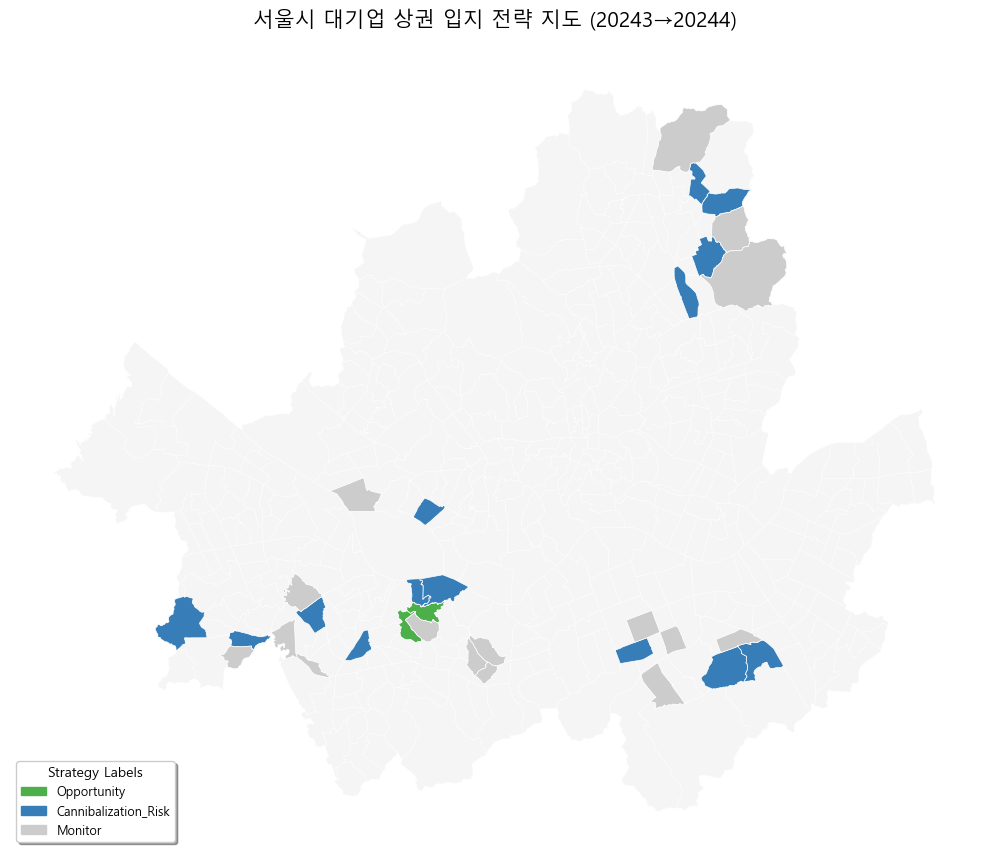

In [27]:
import matplotlib.patches as mpatches

# 1. 결합 확인 (데이터가 비어있는지 체크용)
print(f"결합 전 데이터 수: {len(strat_pdf)}")
print(f"결합 후 지도 데이터 수: {len(g_strat)}")

if len(g_strat) == 0:
    print("⚠️ 경고: 지도 데이터와 전략 데이터가 결합되지 않았습니다. '행정동_코드' 형식을 확인하세요.")

# 2. 시각화 시작
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# 배경 지도
g_seoul.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.3)

# 전략별 채색 및 범례용 핸들 생성
legend_handles = []
for st, color in colors.items():
    # 해당 전략에 해당하는 데이터만 추출
    sub = g_strat[g_strat["Strategy"] == st]
    
    # 데이터가 있는 경우에만 그리고 범례에 추가
    if not sub.empty:
        sub.plot(ax=ax, color=color, edgecolor="white", linewidth=0.5)
        # 범례 아이템 추가
        patch = mpatches.Patch(color=color, label=st)
        legend_handles.append(patch)

# 3. 범례 설정 (좌측 하단)
if legend_handles:
    ax.legend(handles=legend_handles, 
              loc="lower left", 
              fontsize=9, 
              title="Strategy Labels", 
              frameon=True,
              shadow=True)

ax.set_title(f"서울시 대기업 상권 입지 전략 지도 ({T_PREV}→{T_CUR})", fontsize=15, pad=20)
ax.axis("off")
fig.tight_layout()

# 4. 저장
out_path = OUT_DIR_STRAT / f"strategy_map_{T_PREV}_{T_CUR}.png"
fig.savefig(out_path, dpi=300)
print(f"✅ 범례 포함 지도 저장 완료: {out_path}")

plt.show()

## 4) "대기업 상권 전략 알고리즘" 으로 해석 확장 (전략 프레임)